In [2]:
!pip install colorama
!pip install scikeras

In [ ]:
# Install keras-tuner if not already installed
#!pip install keras-tuner
#!pip install colorama

import pandas as pd
import numpy as np
import os
import xml.etree.ElementTree as ET
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image, ImageDraw
import itertools
from sklearn.preprocessing import OneHotEncoder
from colorama import Fore, Back, Style
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential

import keras_tuner as kt

In [ ]:
def read_annotations(xml_path):
    '''
    This function reads the ‘xml’ files containing the annotations
    Input: path to the xml file
    Output: a list containing the label and the annotations
    '''
    # Parse the XML file
    tree = ET.parse(xml_path)

    # Get the root element of the XML tree
    root = tree.getroot()

    # Initialize an empty list to store the annotations
    annotations = []

    # Loop through <object> elements in the XML
    for obj in root.findall('object'):

        # Extract the label from the <name> element
        name = obj.find('name').text

        # Extract the bounding box coordinates from the <bndbox> element
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        annotations.append((name, (xmin, ymin, xmax, ymax)))

    # Return the list of annotations
    return annotations

In [ ]:
# This function reads the images from the files
def read_data(file_names):
    '''
    This function reads the images from the files.
    Returns a tuple:
    data: The data with images an corresponding annotations
    dims: List of all dimensions encountered throughout the dataset
    '''
    # Initialize two empty lists
    data = []
    dims = []

    # Loop over the file names extracted and read the images and annotations
    for file_name in file_names:

        # Get the paths to the files
        img_path = os.path.join(data_dir, 'JPEGImages',
                                file_name + '.jpg')
        xml_path = os.path.join(data_dir, 'Annotations',
                                'Horizontal_Bounding_Boxes',
                                file_name + '.xml')

        # Read the image
        img = Image.open(img_path)

        # Exclude 4-channel images
        if (np.array(img).shape[2]) != 3:
            continue

        # Extract annotations
        annotations = read_annotations(xml_path)

        # Get the dimensions of all objects and store it for later use
        for annot in annotations:
            width = abs(annot[1][0] - annot[1][2])
            height = abs(annot[1][1] - annot[1][3])
            dims.append(width)
            dims.append(height)

        data.append((img, annotations))


    return data, dims

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from itertools import chain

# Divide the classes into Training/Val/Test sets

# Initialize an empty list to store the annotations and file names
full_list = []

for xml_path in Path('/content/drive/MyDrive/Colab_Notebooks/ac_data/Annotations/Horizontal_Bounding_Boxes').glob("*"):
  tree = ET.parse(xml_path)
  root = tree.getroot()
  annotations = []
  for obj in root.findall('object'):
    name = obj.find('name').text
    pair = tuple([int(re.findall("\d+", str(name))[0]), int(re.findall("\d+", str(xml_path))[0])])
    annotations.append(pair)
  full_list.append(annotations)

flat_list = []

for xs in full_list:
    for x in xs:
        flat_list.append(x)

#Store annotations and file names in a dict

d = dict()
[d [t [0]].append(t [1]) if t [0] in list(d.keys())
 else d.update({t [0]: [t [1]]}) for t in flat_list]

# Divide the annotations into 60/20/20 split
train_list = []
val_list = []
test_list = []

list_val = []
for a in d.values():
  list_val.append(a)

for b in list_val:
  total = int(len(b))
  train_len = int(len(b)*0.6)
  val_len = int(len(b)*0.2)+train_len
  test_len = int(len(b)*0.2)+val_len

  if test_len!=total:
    diff = (abs(test_len-total))

    train_len=train_len+diff
    val_len = int(len(b)*0.2)+train_len
    test_len = int(len(b)*0.2)+val_len

  train_list.append(b[:train_len])
  val_list.append(b[train_len:val_len])
  test_list.append(b[val_len:])


flat_train_list = []

for xs in train_list:
    for x in xs:
        flat_train_list.append(x)


flat_val_list = []

for ys in val_list:
    for y in ys:
        flat_val_list.append(y)


flat_test_list = []

for zs in test_list:
    for z in zs:
        flat_test_list.append(z)

# Merge into one list to remove duplications
full_to_merge = [flat_train_list, flat_val_list, flat_test_list]
flat_full_to_merge = []

for ws in full_to_merge:
    for w in ws:
        flat_full_to_merge.append(w)

ordered_list = []
ordered = dict.fromkeys(flat_full_to_merge)
for i in ordered.keys():
  ordered_list.append(i)

# Split into Train/Val/Test sets
train = ordered_list[:2305]
val = ordered_list[2306:3074]
test = ordered_list[3075:3842]

print(len(train))
print(len(val))
print(len(test))








2305
768
767


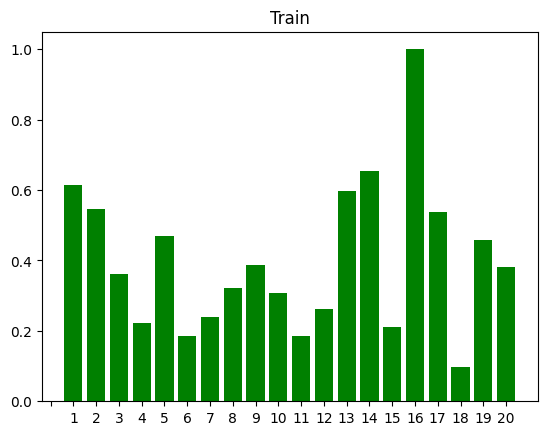

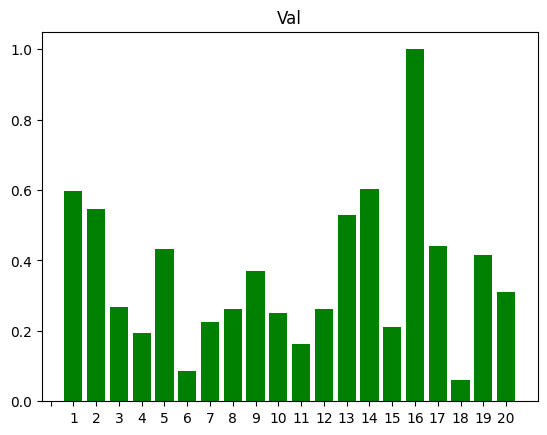

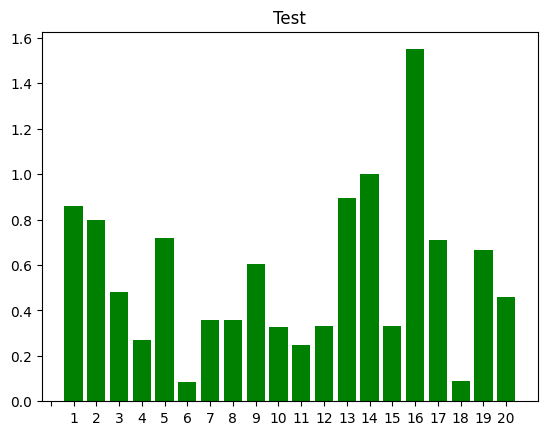

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt


def make_plot(dataset, max, label):
  train_id = []
  for xml_path in Path('/content/drive/MyDrive/Colab_Notebooks/ac_data/Annotations/Horizontal_Bounding_Boxes').glob("*"):
    for i in dataset:
      if str(i) in str(xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()
        annotations = []
        for obj in root.findall('object'):
          name = obj.find('name').text
          id = int(re.findall("\d+", str(name))[0])

          train_id.append(id)


  train_dict = (dict(sorted(dict(Counter(train_id)).items())))

  norm_vals = []
  for i in train_dict.values():
    norm = i/max
    norm_vals.append(norm)

  plt.bar(list(train_dict.keys()), norm_vals, color='g')
  x = [" ", 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
  xi = list(range(len(x)))
  plt.xticks(xi, x)

  plt.title(label)
  plt.show()

make_plot(train, 16960, "Train")
make_plot(val, 2773, "Val")
make_plot(test, 1680, "Test")


In [ ]:
# Write files to train/val/test
'''
train_list = []
for a in os.listdir('/content/drive/MyDrive/Colab_Notebooks/ac_data/per_class/test'):
  if a.endswith('.jpg'):
    id = a.split('.')[0]
    train_list.append(id)

with open("/content/drive/MyDrive/Colab_Notebooks/ac_data/ImageSets/Main/test.txt", "w") as outfile:
    outfile.write("\n".join(train_list))'''

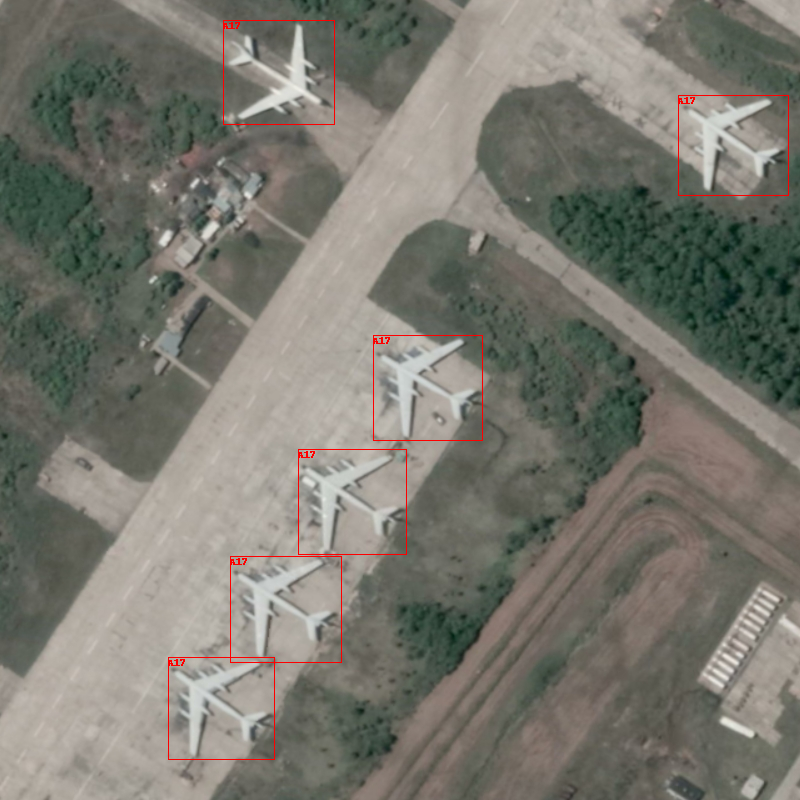

In [ ]:
# Define the path to the data directory
data_dir = '/content/drive/MyDrive/Colab_Notebooks/ac_data'

# Read the train and test filenames from the ImageSets/Main folder
with open(os.path.join(data_dir, 'ImageSets/Main/train.txt'), 'r') as f:
    filenames = f.read().splitlines()
data_train, train_obj_dims = read_data(filenames)

with open(os.path.join(data_dir, 'ImageSets/Main/val.txt'), 'r') as f:
    filenames = f.read().splitlines()
data_val, val_obj_dims = read_data(filenames)

with open(os.path.join(data_dir, 'ImageSets/Main/test.txt'), 'r') as f:
    filenames = f.read().splitlines()
data_test, test_obj_dims = read_data(filenames)

# Display an exmple
img = data_val[0][0]
draw = ImageDraw.Draw(img)
objects = data_val[0][1]
for obj in objects:
    draw.rectangle(obj[1], outline='red')
    draw.text((obj[1][0], obj[1][1]), obj[0], fill='red')
img

In [ ]:
def pad_img(img):
    '''
    This function transforms an image to the desired size.
    If squared, the image remains the same in ratio;
    if rectnagular, it'll be padded evenly to become a squared one.
    '''
    # Get the dimensions the image
    old_size = img.size

    # Define the desired size to transform the image to
    desired_size = (224,224)

    # Calculate the maximum dimension of the original image
    max_dim = max(old_size)

    # Create a new image with the max_dim as the width and height
    padded = Image.new("RGB", (max_dim, max_dim))

    # Calculate the padding for the image to make it square
    x = (max_dim - old_size[0]) // 2
    y = (max_dim - old_size[1]) // 2

    # Paste the original image onto the padded image at the calculated position
    padded.paste(img, (x, y))

    # Resize the padded image to the desired size
    out_img = padded.resize(desired_size)

    # Return the transformed image
    return out_img

In [ ]:
def extract_obj(img, annotations):
    '''
    This function extracts objects from an image based on provided annotations
    '''
    # Define lists to keep objects in an image and their labels
    objects = []
    labels = []

    # Loop through annotations, each of which contain a label and
    # a bounding box denoted by 'b_box'
    for label, b_box in annotations:
        labels.append(label)
        roi = img.crop(b_box)

        # Add roi to the list
        objects.append(roi)


    # Convert labels to numpy array
    labels = np.array(labels)

    # Return objects as individual images as well as their labels
    return objects, labels

In [ ]:
def preprocessing(data):

    # Define two temporary lists to store objects and labels
    X_temp = []
    y_temp = []


    # Iterate over images and annotations to prepare X_train and y_train
    for img, annotations in data:

        # Extract the objects from current image
        objects, labels = extract_obj(img, annotations)

        # Pad objects
        padded = []
        for obj in objects:
            padded_img = pad_img(obj)
            padded.append(padded_img)

        # Add the objects to two temporary lists
        X_temp.append(padded)
        y_temp.append(labels)


    # Flatten the list of labels and convert to numpy array
    orig_labels = list(itertools.chain(*y_temp))
    orig_labels_np = np.array(orig_labels).reshape(-1, 1)

    # Encode the labels
    encoder = OneHotEncoder()
    y = encoder.fit_transform(orig_labels_np).toarray()

    n_channels = 3

    X_list = []

    # Normalize and create a list of image arrays
    for img in X_temp:
        for obj in img:
            X_list.append(np.array(obj)/255.0)

    # Convert the list of images to an array
    X = np.array(X_list)

    return X, y, orig_labels_np

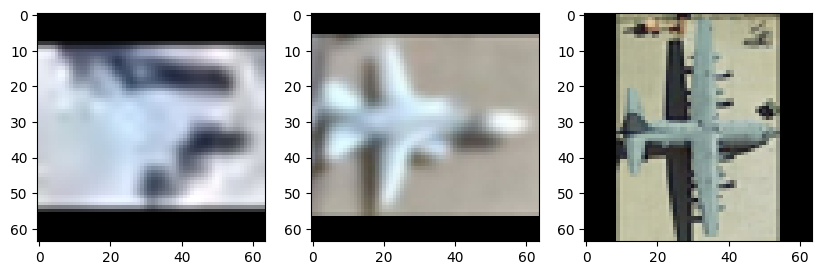

In [ ]:
from re import X
# Get features and labels
x_train, y_train, orig_labels_train = preprocessing(data_train)
x_val, y_val, orig_labels_val = preprocessing(data_val)
x_test, y_test, orig_labels_test = preprocessing(data_test)

n_labels = y_train.shape[1]

# Display some of the padded objects
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 3))
ax0.imshow(x_train[np.argmin(train_obj_dims)//2], cmap='gray')
ax1.imshow(x_train[30], cmap='gray')
ax2.imshow(x_train[np.argmax(train_obj_dims)//2], cmap='gray')

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras import regularizers

tf.random.set_seed(221)

model = Sequential()
model.add(VGG16(include_top = False, weights = 'imagenet', input_shape = (64,64,3)))
model.add(layers.Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=4096,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=20, activation="sigmoid", kernel_regularizer=regularizers.l2(0.01)))

opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ ?                           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='max', min_delta=0.000005,  restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=60, validation_data = (x_val, y_val),callbacks=[es])

Epoch 1/60
419/419 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - accuracy: 0.2995 - loss: 0.5942 - val_accuracy: 0.8436 - val_loss: 0.3912
Epoch 2/60
419/419 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.8462 - loss: 0.3783 - val_accuracy: 0.8903 - val_loss: 0.3281


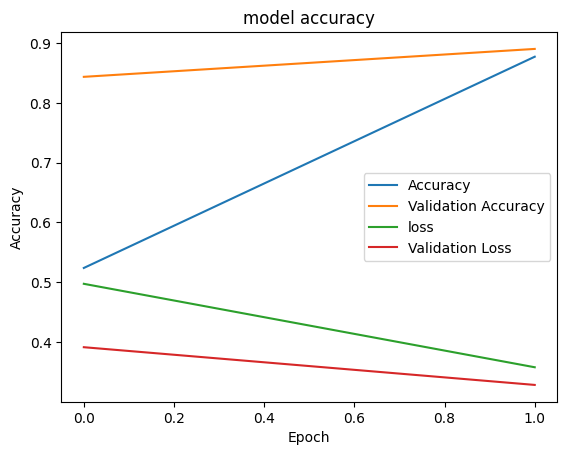

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step


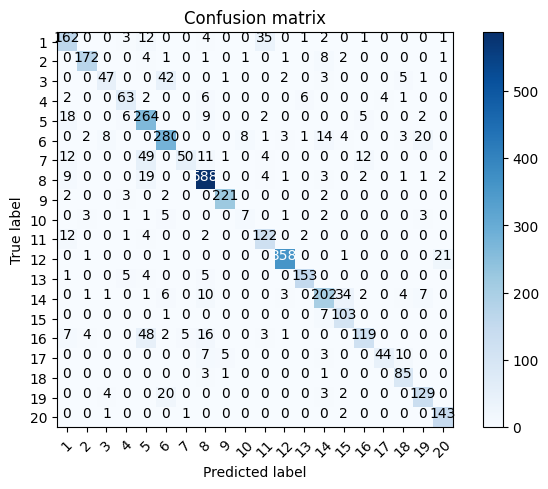

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)

# Assuming y_test is in one-hot encoded format, convert it to multiclass
y_test_classes = np.argmax(y_test, axis=1)

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test_classes, Y_pred_classes) # Use y_test_classes

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes=range(1, 21,1))

In [ ]:
score = confusion_mtx.diagonal()/confusion_mtx.sum(axis=0)

count = 0 # in case items is empty and you need it after the loop
for count, item in enumerate(score, start=1):
    print(count, item)

print("Overall Accuracy " + str(sum(score)/20))

1 0.72
2 0.9398907103825137
3 0.7704918032786885
4 0.7682926829268293
5 0.6470588235294118
6 0.7777777777777778
7 0.8928571428571429
8 0.8882175226586103
9 0.9650655021834061
10 0.4375
11 0.7134502923976608
12 0.9675675675675676
13 0.9386503067484663
14 0.808
15 0.6959459459459459
16 0.8439716312056738
17 0.9166666666666666
18 0.7798165137614679
19 0.7914110429447853
20 0.8511904761904762
Overall Accuracy 0.8056911204511545


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras import regularizers

model2 = Sequential()
model2.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model2.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

model2.add(Flatten())

model2.add(Dense(units=4096,activation="relu"))
model2.add(Dropout(0.3))
model2.add(Dense(units=4096,activation="relu"))
model2.add(Dropout(0.3))
model2.add(Dense(units=20, activation="sigmoid", kernel_regularizer=regularizers.l2(0.01)))

opt = keras.optimizers.Adam(learning_rate=0.00001)
model2.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model2.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │       8,392,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 39,970,644 (152.48 MB)

 Trainable params: 39,970,644 (152.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#es = EarlyStopping(monitor='val_loss', mode='max', min_delta=0.000005,  restore_best_weights=True)
history2 = model2.fit(x_train, y_train, epochs=60, validation_data = (x_val, y_val))

Epoch 1/60
419/419 ━━━━━━━━━━━━━━━━━━━━ 44s 65ms/step - accuracy: 0.0867 - loss: 0.7131 - val_accuracy: 0.1270 - val_loss: 0.5056
Epoch 2/60
419/419 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.0886 - loss: 0.4894 - val_accuracy: 0.0668 - val_loss: 0.4335
Epoch 3/60
419/419 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.0908 - loss: 0.4216 - val_accuracy: 0.1427 - val_loss: 0.3769
Epoch 4/60
419/419 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.1526 - loss: 0.3594 - val_accuracy: 0.3000 - val_loss: 0.3028
Epoch 5/60
419/419 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.2912 - loss: 0.2951 - val_accuracy: 0.3227 - val_loss: 0.2675
Epoch 6/60
419/419 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.3330 - loss: 0.2579 - val_accuracy: 0.3603 - val_loss: 0.2363
Epoch 7/60
419/419 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.3776 - loss: 0.2304 - val_accuracy: 0.4144 - val_loss: 0.2129
Epoch 8/60
419/419 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.3931 - loss: 0.2111 - 

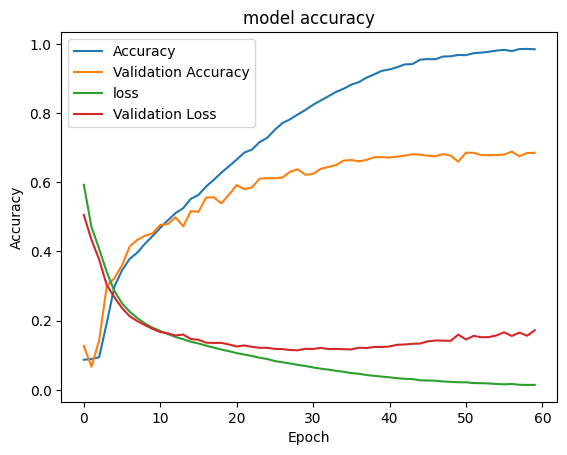

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history2.history["accuracy"])
plt.plot(history2.history['val_accuracy'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()